In [1]:
import sys
import numpy as np
import pandas as pd
# from scipy.misc import imread
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import cv2
import time

# import tensorflow 
from tensorflow.keras import initializers

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate, Layer
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform

# from tensorflow.keras.engine.topology import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng

In [2]:
save_path = r"E:\Lo\one-shot-implement\pickle_file"

In [3]:
"Load data from pickle file"
with open(os.path.join(save_path, "train-augment.pickle"), "rb") as f:
    (Xtrain, train_classes) = pickle.load(f)
with open(os.path.join(save_path, "val-augment.pickle"), "rb") as f:
    (Xval, val_classes) = pickle.load(f)
print(Xtrain.shape)

(1015, 40, 105, 105)


In [4]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,kernel_initializer=initializers.RandomNormal(stddev=0.01,mean=0.0),kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initializers.RandomNormal(stddev=0.01,mean=0.0),
                     bias_initializer=initializers.RandomNormal(stddev=0.01,mean=0.5), kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.01,mean=0.0),
                     bias_initializer=initializers.RandomNormal(stddev=0.01,mean=0.5), kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.01,mean=0.0),
                     bias_initializer=initializers.RandomNormal(stddev=0.01,mean=0.5), kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initializers.RandomNormal(stddev=0.01,mean=0.0),bias_initializer=initializers.RandomNormal(stddev=0.01,mean=0.5)))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initializers.RandomNormal(stddev=0.01,mean=0.5))(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net


In [5]:
model = get_siamese_model((105, 105, 1))
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4096)         38947648    input_1[0][0]                    
                                                        

In [6]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
def get_batch(batch_size,s="train"):
    """Create batch of n pairs, half same class, half different class"""
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape

    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
    
    return pairs, targets

In [8]:
def make_oneshot_task(N, s="val", language=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape
    indices = rng.randint(0, n_examples,size=(N,))
    if language is not None: # if language is specified, select characters for that language
        low, high = categories[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low,high),size=(N,),replace=False)
    else: # if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes),size=(N,),replace=False)            
    true_category = categories[0]
    #get two randome index for true category
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    #create N test image of true categories
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    #create N support set from random categories and indices
    support_set = X[categories,indices,:,:]
    #set the first image of support set is the true image
    support_set[0,:,:] = X[true_category,ex2,:,:]
    support_set = support_set.reshape(N, w, h,1)
    #create N targets
    targets = np.zeros((N,))
    #set the first target is true
    targets[0] = 1
    #shuffle the index of 3 arrays
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets

In [9]:
def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [10]:
# Hyper parameters
evaluate_every = 200 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 200000 # No. of training iterations
N_way = 20 # how many classes for testing one-shot tasks
n_val = 250 # how many one-shot tasks to validate on
best = -1

In [11]:
model_path = "E:\Lo\one-shot-implement\save_model"

In [12]:
model.load_weights(os.path.join(model_path, "weights-full.43800-95.2.h5"))

In [59]:
#function for concatenate images
def concat_images(X,predict_num,ground_num):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    coor1 = ()
    coor2 =()
    for example in range(nc):
        if example == predict_num :
            coor1 = (y*w,x*h)
        if example == ground_num :
            coor2 = (y*w,x*h)
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        x += 1
        if x >= n:
            x = 0
            y += 1
    return img,coor1,coor2

In [60]:
# visualize testing
def plot_oneshot_task(pairs,p_num,g_num):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img,coor1,coor2 = concat_images(pairs[1],p_num,g_num)
    print(coor1,coor2)
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    rect1 = patches.Rectangle(coor1,105,105,linewidth=1,edgecolor='r',facecolor='none')
    rect2 = patches.Rectangle(coor2,105,105,linewidth=1,edgecolor='g',facecolor='none')
    ax2.add_patch(rect2)
    ax2.add_patch(rect1)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()



In [15]:
# def calculate_coor(number,w,h):
#     residule = number 


(315, 105) (315, 105)


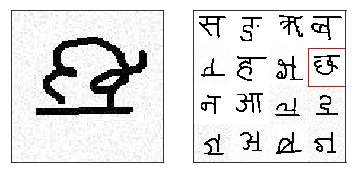

-------Ground Truth------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
13
-------Model Predict-----
[[8.0962205e-01]
 [7.7119470e-04]
 [2.0415276e-02]
 [6.9272816e-03]
 [6.8869954e-01]
 [7.4591953e-01]
 [5.6663156e-04]
 [5.2779317e-03]
 [4.7366688e-01]
 [4.6986341e-04]
 [5.8706760e-02]
 [2.0169616e-03]
 [2.6537621e-01]
 [9.8763525e-01]
 [1.7159522e-02]
 [5.0705671e-04]]
13


In [68]:
# Example of concat image visualization
#run this cell again for change the result testing
pairs, targets = make_oneshot_task(16,"train","Sanskrit")
predict = model.predict(pairs)
#result of grouth_truth
p_num = np.argmax(predict)
#result of model predict
g_num = np.argmax(targets)
plot_oneshot_task(pairs,p_num,g_num)
print("-------Ground Truth------")
print(targets)
print(g_num)
print("-------Model Predict-----")
print(predict)
print(p_num)
